# _**Movie Recommender System**_ #

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import warnings
from surprise import Reader, Dataset, KNNBasic, SVD
import joblib
import random
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)

In [2]:
movies = pd.read_csv("../data/processed data/movies_metadata.csv")
ratings = pd.read_csv("../data/processed data/ratings_small.csv")
links = pd.read_csv("../data/processed data/links_small.csv")
credits = pd.read_csv("../data/processed data/credits.csv")
keywords = pd.read_csv("../data/processed data/keywords.csv")

In [3]:
print("Shapes:")
print("movies:", movies.shape)
print("ratings:", ratings.shape)
print("links:", links.shape)
print("keywords:", keywords.shape)
print("credits:", credits.shape)

Shapes:
movies: (45466, 28)
ratings: (100004, 4)
links: (9125, 3)
keywords: (46419, 3)
credits: (45476, 14)


In [4]:
print("movies columns:", movies.columns.tolist())
print("ratings columns:", ratings.columns.tolist())
print("links columns:", links.columns.tolist())
print("keywords columns:", keywords.columns.tolist())
print("credits columns:", credits.columns.tolist())

movies columns: ['adult', 'budget', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'name_belongs_to_collection', 'id_belongs_to_collection', 'poster_path_belongs_to_collection', 'backdrop_path_belongs_to_collection', 'name_genres', 'id_genres', 'name_production_countries', 'iso_3166_1_production_countries', 'name_production_companies', 'id_production_companies']
ratings columns: ['userId', 'movieId', 'rating', 'timestamp']
links columns: ['movieId', 'imdbId', 'tmdbId']
keywords columns: ['id', 'name_keywords', 'id_keywords']
credits columns: ['id', 'name_crew', 'department_crew', 'gender_crew', 'job_crew', 'profile_path_crew', 'id_crew', 'name_cast', 'order_cast', 'gender_cast', 'credit_id_cast', 'profile_path_cast', 'id_cast', 'character_cast']


In [5]:
links = links.dropna(subset=["tmdbId", "movieId"])
links["tmdbId"] = pd.to_numeric(links["tmdbId"], errors="coerce")
links = links.dropna(subset=["tmdbId"]).astype({"tmdbId": int, "movieId": int})
ml_to_tmdb = dict(zip(links["movieId"], links["tmdbId"]))

In [6]:
print("original ratings rows:", len(ratings))
ratings = ratings[ratings["movieId"].isin(ml_to_tmdb.keys())].copy()
ratings["tmdbId"] = ratings["movieId"].map(ml_to_tmdb)
print("ratings after mapping:", len(ratings))

original ratings rows: 100004
ratings after mapping: 99933


In [7]:
ratings = ratings.copy()
if not np.issubdtype(ratings["timestamp"].dtype, np.datetime64):
    ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s", errors="coerce")
ratings = ratings.sort_values(["userId", "timestamp"])

In [8]:
train_parts, test_parts = [], []
for uid, g in ratings.groupby("userId"):
    g = g.sort_values("timestamp")
    n = len(g)
    if n < 5:
        train_parts.append(g)
        continue
    cutoff = int(n * 0.8)
    train_parts.append(g.iloc[:cutoff])
    test_parts.append(g.iloc[cutoff:])

train_df = pd.concat(train_parts, ignore_index=True)
test_df  = pd.concat(test_parts,  ignore_index=True) if test_parts else ratings.iloc[0:0].copy()

In [9]:
min_train_interactions = 3
valid_users = train_df.groupby("userId").size()
valid_users = valid_users[valid_users >= min_train_interactions].index
train_df = train_df[train_df["userId"].isin(valid_users)].copy()
test_df  = test_df[test_df["userId"].isin(valid_users)].copy()

WR (popularity baseline)

In [10]:
for col in ["vote_count", "vote_average", "id", "title"]:
    if col not in movies.columns:
        raise ValueError(f"movies missing column {col}")

movies_small = movies[["id", "title", "vote_count", "vote_average", "popularity"]].copy()
movies_small["vote_count"] = pd.to_numeric(movies_small["vote_count"], errors="coerce").fillna(0)
movies_small["vote_average"] = pd.to_numeric(movies_small["vote_average"], errors="coerce").fillna(0)

C = movies_small["vote_average"].mean()
m = movies_small["vote_count"].quantile(0.80)

def imdb_weighted_rating(row, m=m, C=C):
    v = row["vote_count"]
    R = row["vote_average"]
    return (v / (v + m)) * R + (m / (v + m)) * C if (v + m) > 0 else 0.0

movies_small["wr"] = movies_small.apply(imdb_weighted_rating, axis=1)

movies_small["id"] = pd.to_numeric(movies_small["id"], errors="coerce")

movies_small = movies_small.dropna(subset=["id"])

movies_small["id"] = movies_small["id"].astype(int)

In [11]:
candidate_tmdb = set(ml_to_tmdb.values())
pop_candidates = movies_small[movies_small["id"].isin(candidate_tmdb)].copy()
pop_candidates = pop_candidates.sort_values("wr", ascending=False)
pop_ranked_tmdb = pop_candidates["id"].tolist()
print("Candidates for popularity:", len(pop_ranked_tmdb))

Candidates for popularity: 9099


Content-Based Recommender (CB)

In [12]:
def to_tokens(s):
    if pd.isna(s) or s == "":
        return []
    return [t.strip().replace(" ", "_") for t in str(s).split(",") if t.strip()]

for df in [movies, keywords, credits]:
    df["id"] = pd.to_numeric(df["id"], errors="coerce")
    df.dropna(subset=["id"], inplace=True)
    df["id"] = df["id"].astype(int)

In [13]:
kw_map = keywords[keywords["id"].isin(candidate_tmdb)][["id", "name_keywords"]].set_index("id")["name_keywords"].to_dict()

cast_map = credits[credits["id"].isin(candidate_tmdb)][["id", "name_cast"]].set_index("id")["name_cast"].to_dict()

crew_map = credits[credits["id"].isin(candidate_tmdb)][["id", "name_crew"]].set_index("id")["name_crew"].to_dict()

movies_cb = movies[movies["id"].isin(candidate_tmdb)][["id","overview","tagline","name_genres","title"]].copy()

In [14]:
def build_item_text(row, kw_map=kw_map, cast_map=cast_map, crew_map=crew_map):
    parts = []
    if isinstance(row.get("overview"), str): parts.append(row["overview"])
    if isinstance(row.get("tagline"), str): parts.append(row["tagline"])
    # genres
    for tok in to_tokens(row.get("name_genres")):
        parts.append(f"GENRE_{tok}")
    # keywords
    kws = kw_map.get(row["id"])
    if isinstance(kws, str):
        for tok in to_tokens(kws):
            parts.append(f"KW_{tok}")
    # cast
    cast = cast_map.get(row["id"])
    if isinstance(cast, str):
        for tok in to_tokens(cast)[:10]:
            parts.append(f"CAST_{tok}")
    # crew
    crew = crew_map.get(row["id"])
    if isinstance(crew, str):
        for tok in to_tokens(crew)[:10]:
            parts.append(f"CREW_{tok}")
    return " ".join(parts)

In [15]:
movies_cb["cb_text"] = movies_cb.apply(build_item_text, axis=1)
print("CB items:", len(movies_cb))

CB items: 9099


TF-IDF

In [16]:
vectorizer = TfidfVectorizer(max_features=50000, min_df=2, ngram_range=(1,2))
X_items = vectorizer.fit_transform(movies_cb["cb_text"])

item_index = {tmdb_id: idx for idx, tmdb_id in enumerate(movies_cb["id"].tolist())}
index_item = {idx: tmdb_id for tmdb_id, idx in item_index.items()}

print("X_items shape:", X_items.shape)

X_items shape: (9099, 50000)


User profiles(cb)

In [17]:
train_tmdb = train_df[train_df["tmdbId"].isin(item_index.keys())].copy()
train_tmdb["item_idx"] = train_tmdb["tmdbId"].map(item_index)

user_ids = sorted(train_tmdb["userId"].unique())
uid_to_index = {u:i for i,u in enumerate(user_ids)}


train_user_mean = train_df.groupby("userId")["rating"].mean().to_dict()
train_tmdb["w"] = train_tmdb.apply(lambda r: r["rating"] - train_user_mean[r["userId"]], axis=1)

rows = train_tmdb["item_idx"].astype(int).to_numpy()
cols = train_tmdb["userId"].map(uid_to_index).astype(int).to_numpy()
data = train_tmdb["w"].astype(np.float32).to_numpy()

M = sparse.coo_matrix((data, (rows, cols)), shape=(X_items.shape[0], len(uid_to_index))).tocsr()

user_cb_profiles = M.T.dot(X_items)
user_cb_profiles = normalize(user_cb_profiles.tocsr(), norm="l2", axis=1)

print("user_cb_profiles shape:", user_cb_profiles.shape)

user_cb_profiles shape: (671, 50000)


In [18]:
def build_user_profile(uid, ratings_df, item_index, X_items):
    """Build user profile as weighted mean of seen item vectors"""
    if uid not in ratings_df["userId"].values:
        return None
    rows = []
    weights = []
    user_mean = ratings_df[ratings_df["userId"]==uid]["rating"].mean()
    for _, row in ratings_df[ratings_df["userId"]==uid].iterrows():
        tmdb = row["tmdbId"]
        if tmdb not in item_index: continue
        idx = item_index[tmdb]
        rows.append(X_items[idx])
        weights.append(row["rating"] - user_mean)
    if not rows:
        return None
    mat = np.vstack([r.toarray() for r in rows])
    w = np.array(weights).reshape(-1,1)
    prof = (mat * w).mean(axis=0)
    return prof

In [19]:
def explain_recommendation(movie_id, user_seen_ids, movies_meta, kw_map, cast_map):
    """Generate short natural explanation (genre/actor overlap)."""
    explanation = []
    movie_genres = set(to_tokens(movies_meta.loc[movies_meta["id"]==movie_id,"name_genres"].values[0]))
    movie_cast = set(to_tokens(cast_map.get(movie_id,"")))
    # compare with seen movies
    seen_genres = set()
    seen_cast = set()
    for sid in user_seen_ids:
        if sid in movies_meta["id"].values:
            seen_genres |= set(to_tokens(movies_meta.loc[movies_meta["id"]==sid,"name_genres"].values[0]))
            seen_cast |= set(to_tokens(cast_map.get(sid,"")))
    g_common = movie_genres & seen_genres
    c_common = movie_cast & seen_cast
    if g_common:
        explanation.append(f"genre common: {list(g_common)[0]}")
    elif c_common:
        explanation.append(f"cast common: {list(c_common)[0]}")
    else:
        explanation.append("explanation")
    return "، ".join(explanation)

Recommender function(CB)

In [20]:
def recommend_popular(k, exclude_set=None):
    rec = []
    for tmdb in pop_ranked_tmdb:
        if exclude_set and tmdb in exclude_set:
            continue
        rec.append(tmdb)
        if len(rec) >= k:
            break
    return rec

In [21]:
def recommend_cb(user_id, k=10, exclude_set=None, min_score=0.0, cold_start_prefs=None):
    # cold-start
    if user_id not in uid_to_index:
        if cold_start_prefs and isinstance(cold_start_prefs,str):
            # make synthetic profile
            synthetic_vec = vectorizer.transform([cold_start_prefs])
            sims = (synthetic_vec @ X_items.T).toarray().ravel()
            order = np.argsort(-sims)
            rec = []
            for iidx in order:
                tmdb = index_item.get(iidx)
                if tmdb is None: continue
                if exclude_set and tmdb in exclude_set: continue
                rec.append((tmdb, sims[iidx]))
                if len(rec) >= k: break
            return [t for t, s in rec]
        else:
            # fallback to popularity
            return recommend_popular(k, exclude_set)

    # normal CB
    u_idx = uid_to_index[user_id]
    uvec = user_cb_profiles[u_idx, :]
    if uvec.nnz == 0:
        return recommend_popular(k, exclude_set)

    sims = (uvec @ X_items.T).toarray().ravel()
    order = np.argsort(-sims)
    rec = []
    for iidx in order:
        tmdb = index_item.get(iidx)
        if tmdb is None: continue
        if exclude_set and tmdb in exclude_set: continue
        if sims[iidx] >= min_score:
            rec.append((tmdb, sims[iidx]))
        if len(rec) >= k: break
    return [t for t, s in rec]

Collaborative Filtering

In [22]:
n_items = X_items.shape[0]

In [23]:
df_sur = train_tmdb[["userId","item_idx","rating"]].copy()
df_sur["userID"] = df_sur["userId"].map(uid_to_index).astype(str)
df_sur["itemID"] = df_sur["item_idx"].astype(str)

min_r = float(df_sur["rating"].min())
max_r = float(df_sur["rating"].max())
reader = Reader(rating_scale=(min_r, max_r))
data = Dataset.load_from_df(df_sur[["userID","itemID","rating"]], reader)

In [24]:
def _minmax(v):
    v = np.asarray(v, dtype=np.float32)
    if v.size == 0:
        return v
    vmin, vmax = float(np.min(v)), float(np.max(v))
    if not np.isfinite(vmin) or vmax - vmin < 1e-9:
        return np.zeros_like(v)
    return (v - vmin) / (vmax - vmin)

similarity

In [25]:
sim_options = {
    'name': 'pearson',
    'user_based': False
}
algo_sim = KNNBasic(k=40, min_k=5, sim_options=sim_options)
trainset = data.build_full_trainset()
algo_sim.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [26]:
def cf_item_item_scores(user_id):
    scores = np.zeros(n_items, dtype=np.float32)
    if user_id not in uid_to_index:
        return scores
    u_idx = uid_to_index[user_id]
    for i in range(n_items):
        scores[i] = algo_sim.predict(str(u_idx), str(i)).est
    return _minmax(scores)

Matrix Factorization

In [27]:
algo_mf = SVD(n_factors=50, n_epochs=10, lr_all=0.005, reg_all=0.02, biased=True, random_state=42)
trainset = data.build_full_trainset()
algo_mf.fit(trainset)

In [28]:
def mf_scores_for_user(user_id):
    scores = np.zeros(n_items, dtype=np.float32)
    if user_id not in uid_to_index:
        return scores
    u_idx = uid_to_index[user_id]
    for i in range(n_items):
        scores[i] = algo_mf.predict(str(u_idx), str(i)).est
    return _minmax(scores)

Hybrid

In [29]:
def cf_scores(user_id, method="item-item"):
    if method == "item-item":
        return cf_item_item_scores(user_id)
    elif method == "mf":
        return mf_scores_for_user(user_id)
    else:
        raise ValueError("method not supported")

In [30]:
def recommend_hybrid(user_id, k=10, exclude_set=None, alpha=0.5, cf_method="item-item"):
    # CB scores
    if user_id in uid_to_index:
        u_idx = uid_to_index[user_id]
        cb_scores = (user_cb_profiles[u_idx, :] @ X_items.T).toarray().ravel()
    else:
        cb_scores = None

    # CF scores
    try:
        cf_s = cf_scores(user_id, method=cf_method)
    except Exception:
        cf_s = None

    if cb_scores is None and cf_s is None:
        return recommend_popular(k, exclude_set)

    # normalize available signals to [0,1]
    def norm(v):
        if v is None or np.all(np.isclose(v, v[0] if len(v) > 0 else 0)):
            return None
        v = np.array(v, dtype=np.float32)
        return (v - v.min()) / (v.max() - v.min() + 1e-9)

    cbn = norm(cb_scores)
    cfn = norm(cf_s)

    if cbn is None and cfn is not None:
        s = cfn
    elif cfn is None and cbn is not None:
        s = cbn
    else:
        s = alpha * cfn + (1 - alpha) * cbn

    order = np.argsort(-s)
    rec = []
    for iidx in order:
        tmdb = index_item.get(int(iidx))
        if tmdb is None:
            continue
        if exclude_set and tmdb in exclude_set:
            continue
        rec.append(tmdb)
        if len(rec) >= k:
            break

    if len(rec) < k:
        need = k - len(rec)
        rec += [x for x in recommend_popular(k + need, exclude_set) if x not in rec][:need]

    return rec

evaluation

In [31]:
def precision_at_k(actual, pred, k):
    if k == 0: return 0.0
    return len(set(actual) & set(pred[:k])) / k

def recall_at_k(actual, pred, k):
    if len(actual) == 0: return 0.0
    return len(set(actual) & set(pred[:k])) / len(set(actual))

def ndcg_at_k(actual, pred, k):
    actual = set(actual)
    rel = [1.0 if p in actual else 0.0 for p in pred[:k]]
    dcg = sum([rel[i] / np.log2(i + 2) for i in range(len(rel))])
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(actual), k))])
    return (dcg / idcg) if idcg > 0 else 0.0

def hit_rate_at_k(actual, pred, k):
    return 1.0 if len(set(actual) & set(pred[:k])) > 0 else 0.0

def map_at_k(actual, pred, k):
    actual = set(actual)
    if len(actual) == 0: return 0.0
    hits = 0
    score = 0.0
    for i, p in enumerate(pred[:k], start=1):
        if p in actual:
            hits += 1
            score += hits / i
    return score / min(len(actual), k)

In [32]:
train_seen = (
    train_df.groupby("userId")["tmdbId"]
    .apply(lambda s: set(int(x) for x in s.dropna().tolist()))
    .to_dict()
)

test_truth = (
    test_df.groupby("userId")["tmdbId"]
    .apply(lambda s: [int(x) for x in s.dropna().tolist()])
    .to_dict()
)

test_users = sorted(test_truth.keys())

In [33]:
def preds_cb(uid, k):
    excl = train_seen.get(uid, set())
    try:
        rec = recommend_cb(uid, k=k, exclude_set=excl)
    except Exception:
        rec = []
    return rec[:k]

def preds_cf_mf(uid, k):
    try:
        s = cf_scores(uid, method="mf")
    except Exception:
        return []
    order = np.argsort(-s)
    out = []
    excl = train_seen.get(uid, set())
    for iidx in order:
        mid = index_item.get(int(iidx))
        if mid is None:
            continue
        if mid in excl:
            continue
        out.append(mid)
        if len(out) >= k:
            break
    return out

def preds_cf_item(uid, k):
    try:
        s = cf_scores(uid, method="item-item")
    except Exception:
        return []
    order = np.argsort(-s)
    out, excl = [], train_seen.get(uid, set())
    for iidx in order:
        mid = index_item.get(int(iidx))
        if mid is None or mid in excl:
            continue
        out.append(mid)
        if len(out) >= k:
            break
    return out

def preds_hybrid(uid, k, alpha=0.5, cf_method="mf"):
    excl = train_seen.get(uid, set())
    try:
        rec = recommend_hybrid(uid, k=k, exclude_set=excl, alpha=alpha, cf_method=cf_method)
    except Exception:
        rec = []
    return rec[:k]

In [34]:
def catalog_coverage(all_items, recs, k):
    recommended_items = set()
    for uid, pred in recs.items():
        recommended_items.update(pred[:k])
    return len(recommended_items) / len(all_items)

In [35]:
def novelty_at_k(recs, train_seen, k, item_popularity, n_users):
    vals = []
    for uid, pred in recs.items():
        for item in pred[:k]:
            pop = item_popularity.get(item, 0) / n_users
            if pop > 0:
                vals.append(-np.log2(pop))
    return np.mean(vals) if vals else 0.0

In [36]:
def intra_list_diversity(recs, k, X_items, item_index):
    vals = []
    for uid, pred in recs.items():
        items = [item_index.get(i) for i in pred[:k] if i in item_index]
        if len(items) < 2:
            continue
        vecs = X_items[items]
        sims = cosine_similarity(vecs)
        n = len(items)
        sum_dist = np.sum(1 - sims) / (n*(n-1))
        vals.append(sum_dist)
    return np.mean(vals) if vals else 0.0

In [37]:
def bootstrap_ci(values, n_boot=1000, alpha=0.05):
    if len(values) == 0: return (np.nan, np.nan)
    means = []
    values = np.array(values)
    n = len(values)
    for _ in range(n_boot):
        sample = resample(values, n_samples=n, replace=True)
        means.append(np.mean(sample))
    return np.percentile(means, 100 * (alpha/2)), np.percentile(means, 100 * (1-alpha/2))

In [38]:
def run_evaluation(models, k_list, metrics, test_users, test_truth, train_seen, X_items=None, item_index=None, all_items=None):
    """
    Evaluate models with ranking metrics + coverage, novelty, and diversity.
    """
    n_users = len(train_seen)
    # popularity of items in training
    item_popularity = {}
    for items in train_seen.values():
        for it in items:
            item_popularity[it] = item_popularity.get(it, 0) + 1

    per_user_metrics = {name: {f"{m}@{k}": [] for k in k_list for m in metrics}
                        for name in models.keys()}

    extra_metrics = []  # coverage, novelty, ild

    for name, fn in models.items():
        for k in k_list:
            # collect recs for all users
            recs = {}
            for uid in test_users:
                actual = test_truth.get(uid, [])
                pred = fn(uid, k=k) or []
                recs[uid] = pred

                # ranking metrics
                p = precision_at_k(actual, pred, k)
                r = recall_at_k(actual, pred, k)
                n = ndcg_at_k(actual, pred, k)
                h = hit_rate_at_k(actual, pred, k)
                m = map_at_k(actual, pred, k)

                per_user_metrics[name][f"P@{k}"].append(p)
                per_user_metrics[name][f"R@{k}"].append(r)
                per_user_metrics[name][f"NDCG@{k}"].append(n)
                per_user_metrics[name][f"HR@{k}"].append(h)
                per_user_metrics[name][f"MAP@{k}"].append(m)

            # extra metrics (computed once per model,k)
            if all_items is not None:
                cc = catalog_coverage(all_items, recs, k)
            else:
                cc = np.nan

            nov = novelty_at_k(recs, train_seen, k, item_popularity, n_users) \
                  if item_popularity else np.nan

            ild = intra_list_diversity(recs, k, X_items, item_index) \
                  if (X_items is not None and item_index is not None) else np.nan

            extra_metrics.append({
                "model": name, "k": k,
                "Coverage": cc, "Novelty": nov, "ILD": ild
            })

    # summary table for ranking metrics
    summary_rows = []
    for name in models.keys():
        for k in k_list:
            row = {"model": name, "k": k}
            for m in metrics:
                vals = per_user_metrics[name][f"{m}@{k}"]
                row[m] = np.mean(vals)
                lo, hi = bootstrap_ci(vals, n_boot=500)
                row[f"{m}_ci95"] = f"[{lo:.3f}, {hi:.3f}]"
            summary_rows.append(row)

    df_rank = pd.DataFrame(summary_rows).sort_values(["k","model"]).reset_index(drop=True)
    df_extra = pd.DataFrame(extra_metrics).sort_values(["k","model"]).reset_index(drop=True)

    return df_rank, df_extra

In [39]:
k_list = [10, 20]
metrics = ["P", "R", "NDCG", "HR", "MAP"]

models = {
    "CB": lambda uid, k: preds_cb(uid, k),
    "CF_MF": lambda uid, k: preds_cf_mf(uid, k),
    "HYBRID": lambda uid, k: preds_hybrid(uid, k, alpha=0.5, cf_method="mf"),
    "CF_ITEM": lambda uid, k: preds_cf_item(uid, k)
}

df_rank, df_extra = run_evaluation(
    models,
    k_list,
    metrics,
    test_users,
    test_truth,
    train_seen,
    X_items=X_items,
    item_index=item_index,
    all_items=set(movies_cb["id"].tolist())
)

eval_df = pd.merge(df_rank, df_extra, on=["model","k"])
display(eval_df)

,model,k,P,P_ci95,R,R_ci95,NDCG,NDCG_ci95,HR,HR_ci95,MAP,MAP_ci95,Coverage,Novelty,ILD
0,CB,10,0.035320,"[0.030, 0.041]",0.016852,"[0.014, 0.020]",0.041112,"[0.034, 0.048]",0.248882,"[0.216, 0.281]",0.016427,"[0.013, 0.020]",0.205131,5.948777,0.915060
1,CF_ITEM,10,0.002683,"[0.001, 0.004]",0.000992,"[0.000, 0.002]",0.002488,"[0.001, 0.004]",0.020864,"[0.010, 0.032]",0.000812,"[0.000, 0.002]",0.300154,7.216246,0.981701
2,CF_MF,10,0.037854,"[0.032, 0.043]",0.022163,"[0.018, 0.027]",0.046141,"[0.038, 0.054]",0.254844,"[0.226, 0.289]",0.019716,"[0.016, 0.023]",0.013323,2.857396,0.975198
3,HYBRID,10,0.050671,"[0.044, 0.058]",0.028247,"[0.024, 0.034]",0.061566,"[0.053, 0.071]",0.305514,"[0.271, 0.338]",0.027203,"[0.022, 0.032]",0.023783,2.907601,0.974195
4,CB,20,0.028167,"[0.025, 0.032]",0.026129,"[0.022, 0.031]",0.038853,"[0.034, 0.044]",0.350224,"[0.316, 0.384]",0.012030,"[0.010, 0.015]",0.376129,6.200527,0.945399
5,CF_ITEM,20,0.002534,"[0.002, 0.004]",0.002625,"[0.001, 0.004]",0.003015,"[0.002, 0.004]",0.041729,"[0.027, 0.057]",0.000679,"[0.000, 0.001]",0.399582,7.230559,0.981889
6,CF_MF,20,0.035544,"[0.031, 0.041]",0.039307,"[0.033, 0.046]",0.049984,"[0.043, 0.058]",0.372578,"[0.335, 0.408]",0.017436,"[0.014, 0.021]",0.019489,2.974452,0.979848
7,HYBRID,20,0.041878,"[0.037, 0.047]",0.045329,"[0.039, 0.053]",0.061116,"[0.054, 0.069]",0.433681,"[0.395, 0.472]",0.021736,"[0.018, 0.026]",0.033583,3.063142,0.979235


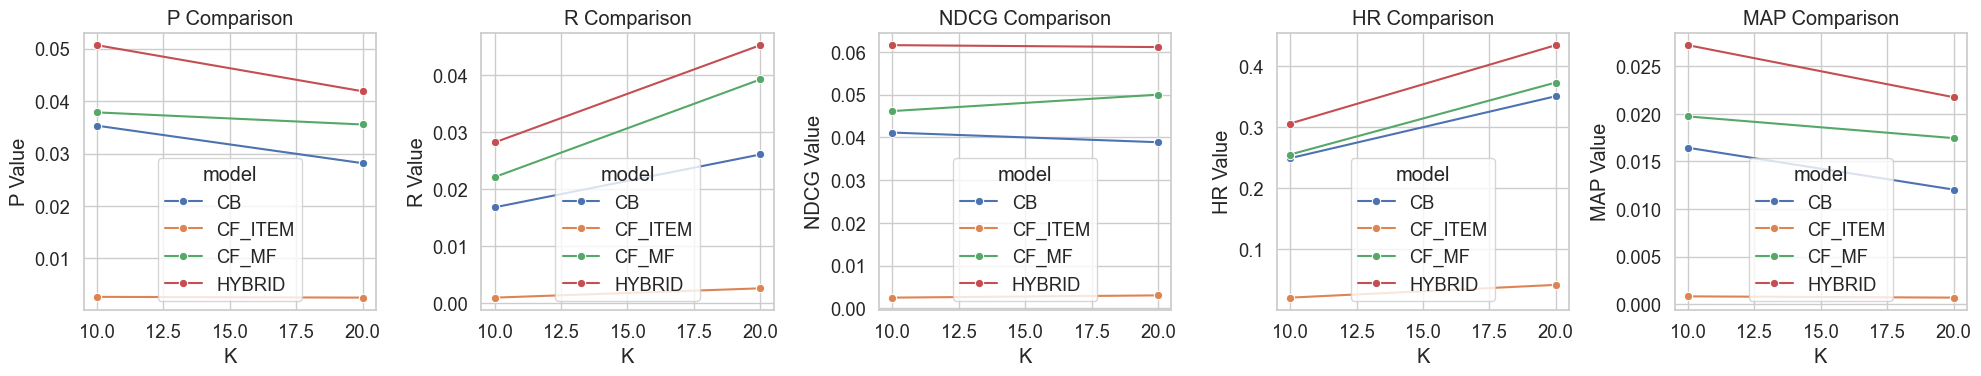

In [40]:
sns.set(style="whitegrid", font_scale=1.2)

plot_metrics = ["P", "R", "NDCG", "HR", "MAP"]

fig, axes = plt.subplots(1, len(plot_metrics), figsize=(20, 4), sharex=True)

for ax, m in zip(axes, plot_metrics):
    sns.lineplot(
        data=eval_df,
        x="k", y=m, hue="model", marker="o", ax=ax
    )
    ax.set_title(f"{m} Comparison")
    ax.set_ylabel(f"{m} Value")
    ax.set_xlabel("K")

plt.tight_layout()
plt.show()

In [41]:
print("\n Ablation 1: remove cast features ...")
vectorizer_no_cast = vectorizer.__class__(**vectorizer.get_params())
X_items_no_cast = vectorizer_no_cast.fit_transform(
    movies["overview"].fillna("") + " " +
    movies["tagline"].fillna("") + " " +
    movies["name_genres"].fillna("")
)
user_cb_profiles_no_cast = X_items_no_cast[ [uid_to_index[u] for u in train_seen.keys()] ]

def preds_cb_no_cast(uid, k):
    if uid not in uid_to_index: return []
    u_idx = uid_to_index[uid]
    uvec = user_cb_profiles_no_cast[u_idx,:]
    sims = (uvec @ X_items_no_cast.T).toarray().ravel()
    order = np.argsort(-sims)
    seen = train_seen.get(uid, set())
    rec=[]
    for iidx in order:
        mid = index_item.get(int(iidx))
        if mid is None or mid in seen: continue
        rec.append(mid)
        if len(rec)>=k: break
    return rec


 Ablation 1: remove cast features ...


In [42]:
models_ab1 = {"CB_no_cast": lambda uid,k: preds_cb_no_cast(uid,k)}

item_index_no_cast = {tmdb_id: idx for idx, tmdb_id in enumerate(movies["id"].tolist())}
index_item_no_cast = {idx: tmdb_id for tmdb_id, idx in item_index_no_cast.items()}

df_rank_ab1, df_extra_ab1 = run_evaluation(
    models_ab1,
    k_list,
    metrics,
    test_users,
    test_truth,
    train_seen,
    X_items=X_items_no_cast,
    item_index=item_index_no_cast,
    all_items=set(movies["id"].tolist())
)

cb_no_cast = pd.merge(df_rank_ab1, df_extra_ab1, on=["model","k"])
display(cb_no_cast)

,model,k,P,P_ci95,R,R_ci95,NDCG,NDCG_ci95,HR,HR_ci95,MAP,MAP_ci95,Coverage,Novelty,ILD
0,CB_no_cast,10,0.004471,"[0.003, 0.006]",0.001354,"[0.001, 0.002]",0.005606,"[0.003, 0.008]",0.041729,"[0.027, 0.057]",0.002039,"[0.001, 0.003]",0.093963,7.343092,0.976129
1,CB_no_cast,20,0.003577,"[0.003, 0.005]",0.002739,"[0.002, 0.004]",0.005153,"[0.004, 0.007]",0.065574,"[0.051, 0.085]",0.001392,"[0.001, 0.002]",0.137257,7.459615,0.976097


In [43]:
print("\n Ablation 2: CountVectorizer ...")
count_vect = CountVectorizer(max_features=20000, stop_words="english")
X_items_count = count_vect.fit_transform(
    movies["overview"].fillna("") + " " +
    movies["tagline"].fillna("") + " " +
    movies["name_genres"].fillna("")
)
user_cb_profiles_count = X_items_count[ [uid_to_index[u] for u in train_seen.keys()] ]

def preds_cb_count(uid, k):
    if uid not in uid_to_index: return []
    u_idx = uid_to_index[uid]
    uvec = user_cb_profiles_count[u_idx,:]
    sims = (uvec @ X_items_count.T).toarray().ravel()
    order = np.argsort(-sims)
    seen = train_seen.get(uid, set())
    rec=[]
    for iidx in order:
        mid = index_item.get(int(iidx))
        if mid is None or mid in seen: continue
        rec.append(mid)
        if len(rec)>=k: break
    return rec


 Ablation 2: CountVectorizer ...


In [44]:
models_ab2 = {"CB_count": lambda uid,k: preds_cb_count(uid,k)}

item_index_count = {tmdb_id: idx for idx, tmdb_id in enumerate(movies["id"].tolist())}
index_item_count = {idx: tmdb_id for tmdb_id, idx in item_index_count.items()}

df_rank_ab2, df_extra_ab2 = run_evaluation(
    models_ab2,
    k_list,
    metrics,
    test_users,
    test_truth,
    train_seen,
    X_items=X_items_count,
    item_index=item_index_count,
    all_items=set(movies["id"].tolist())
)

cb_count = pd.merge(df_rank_ab2, df_extra_ab2, on=["model","k"])
display(cb_count)

,model,k,P,P_ci95,R,R_ci95,NDCG,NDCG_ci95,HR,HR_ci95,MAP,MAP_ci95,Coverage,Novelty,ILD
0,CB_count,10,0.004769,"[0.003, 0.007]",0.001469,"[0.001, 0.002]",0.005757,"[0.004, 0.008]",0.044709,"[0.029, 0.061]",0.002056,"[0.001, 0.003]",0.057161,7.374737,0.962342
1,CB_count,20,0.004545,"[0.004, 0.006]",0.002645,"[0.002, 0.004]",0.005605,"[0.004, 0.007]",0.080477,"[0.061, 0.100]",0.001423,"[0.001, 0.002]",0.082319,7.427162,0.962642


Save Artifacts for App

In [45]:
joblib.dump(vectorizer, "../models/vectorizer.pkl")
joblib.dump(X_items, "../models/X_items.pkl")
joblib.dump(item_index, "../models/item_index.pkl")       # tmdbId -> item_idx
joblib.dump(index_item, "../models/index_item.pkl")       # item_idx -> tmdbId
joblib.dump(user_cb_profiles, "../models/user_cb_profiles.pkl")  # users x features (sparse)

['../models/user_cb_profiles.pkl']

In [46]:
joblib.dump(algo_mf, "../models/algo_mf.pkl")
joblib.dump(algo_sim, "../models/algo_item_item.pkl")

['../models/algo_item_item.pkl']

In [47]:
joblib.dump(uid_to_index, "../models/uid_to_index.pkl")
joblib.dump(train_seen, "../models/train_seen.pkl")

['../models/train_seen.pkl']

In [48]:
movies_meta = movies[["id", "title", "poster_path", "overview", "name_genres"]].copy()
movies_meta["id"] = pd.to_numeric(movies_meta["id"], errors="coerce").astype("Int64")
movies_meta = movies_meta.dropna(subset=["id"]).astype({"id": int}).drop_duplicates("id")

movies_meta_cb = movies_cb[["id","title","overview"]].drop_duplicates("id")
movies_meta_cb = movies_meta_cb.merge(movies_meta[["id","poster_path", "name_genres"]], on="id", how="left")

movies_meta_cb.to_csv("../models/movies_meta.csv", index=False)

In [49]:
pop_candidates.to_csv("../models/pop_candidates.csv", index=False)